## homework 3 - part 2
### message passing graph networks

the goals of this assignment:
1. learn to construct a message passing network (learn about DGLs update functions, build edge and node networks)
2. learn to train an edge classifier, and a node classifier

download the dataset. 

the dataset is made from random graphs, where two points on the graph have been labeled as the start and end points of a path. 

the task is to classify the edges of the graph to determine if they are "part of" the shortest path between the two points.

In [3]:
!wget https://www.dropbox.com/s/2s7yhlrdpovyxtk/Dataset.zip

In [4]:
!unzip Dataset.zip

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dgl
import pandas as pd
import torch
import networkx as nx

Using backend: pytorch


In [3]:
from shortest_path_dataloader import ShortestPathDataset, collate_graphs

In [4]:
training_dataset = ShortestPathDataset('Dataset/training_data/')
validation_dataset = ShortestPathDataset('Dataset/validation_data/')

100%|██████████| 2000/2000 [00:11<00:00, 175.22it/s]


In [7]:
g = training_dataset[18]

In [8]:
g

Graph(num_nodes=22, num_edges=88,
      ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)})

The nodes of the graph have no real "features" - the node features mark the starting and ending points 

starting point (1,0)

ending point (0,1)

In [9]:
g.ndata['node_features']

tensor([[0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

Each edge has a distance associated with it, and the target for training is also stored on the edge data - saying if the edge is part of the path or not

In [10]:
g.edata['distance']

tensor([1.1604, 0.2404, 0.3798, 0.8368, 0.6501, 1.4272, 0.5435, 0.4785, 1.3131,
        0.5248, 1.3791, 0.8572, 1.2499, 1.1502, 1.8081, 0.0734, 0.8205, 1.6806,
        1.9217, 2.0124, 1.6275, 0.5195, 0.2058, 1.5898, 1.2010, 0.7496, 1.3425,
        0.3019, 1.0291, 2.3201, 1.0387, 1.5575, 0.3485, 1.3433, 0.5967, 1.1121,
        1.2569, 0.8405, 1.4750, 0.6145, 0.8453, 0.9447, 1.3736, 0.8007, 1.1604,
        0.2404, 0.3798, 0.8368, 0.6501, 1.4272, 0.5435, 0.4785, 1.3131, 0.5248,
        1.3791, 0.8572, 1.2499, 1.1502, 1.8081, 0.0734, 0.8205, 1.6806, 1.9217,
        2.0124, 1.6275, 0.5195, 0.2058, 1.5898, 1.2010, 0.7496, 1.3425, 0.3019,
        1.0291, 2.3201, 1.0387, 1.5575, 0.3485, 1.3433, 0.5967, 1.1121, 1.2569,
        0.8405, 1.4750, 0.6145, 0.8453, 0.9447, 1.3736, 0.8007])

In [11]:
g.edata['on_path']

tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
g.ndata['on_path']

tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

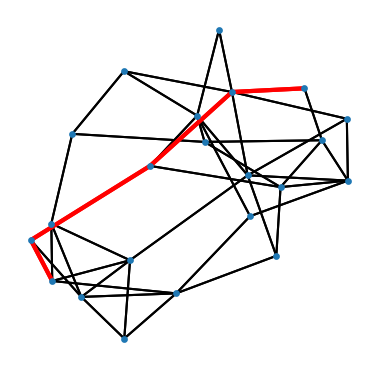

In [14]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(3,3),dpi=150)


nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(g.nodes().data.numpy())
nx_graph.add_edges_from([(es.item(),ee.item()) for es,ee in zip(g.edges()[0],g.edges()[1])])

edge_dict = {(s.item(),e.item()) : on_path.item() for s,e,on_path in zip(g.edges()[0],g.edges()[1],
                                                                         g.edata['on_path'])}
edge_list = [e for i,e in enumerate(nx_graph.edges) if edge_dict[e]>0]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax,arrows=False)



plt.show()

In [15]:
from torch.utils.data import Dataset, DataLoader
data_loader = DataLoader(training_dataset, batch_size=300, shuffle=True,
                         collate_fn=collate_graphs)
validation_data_loader = DataLoader(validation_dataset, batch_size=300, shuffle=False,
                         collate_fn=collate_graphs)

In [16]:
for batched_g in data_loader:
    break

In [17]:
batched_g

Graph(num_nodes=9821, num_edges=39284,
      ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.float32)})

### building the model

what are the building blocks we need?

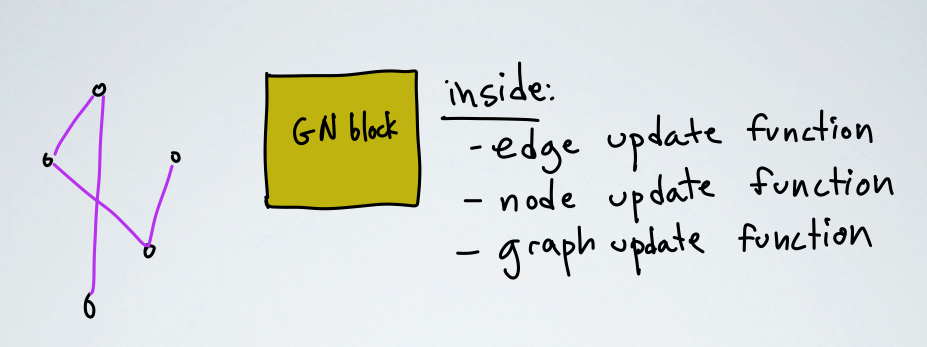

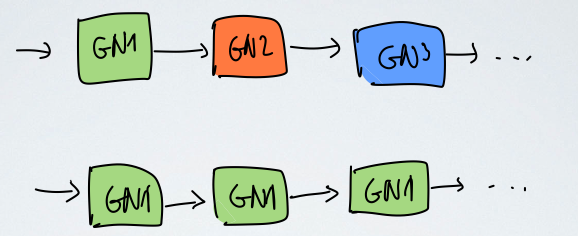

in order to implement the edge and node updates, we use DGLs "update_all" interface

short summary:
-------------------
for details look at the DGL documentation, https://docs.dgl.ai/tutorials/blitz/index.html
Or the tutorial 
Or ask us on slack if the concept isn't clear.


in model.py you have the basic skeleton. you implement an "edge network" and a "node network"

the edge network will act on all the edges in your graph - it will look at the nodes at the "src" and "dst" (source and destination) of the edge and apply a fully connected network to it

then the node network will have access to a "mailbox" with all the information sent by the edges connected to each node. you sum that "mailbox", add to it the existing node hidden represation, and then apply a fully connected network to update the node represation.

after each step of the update, networks take the node and edge represenations and apply a binary classifier to say if its "on path" or not.
the prediction is added to the previous step prediction, and the final result is compared to the target with BCEWithLogitsLoss. for both nodes and edges


we want to implement the model such that it decorates the nodes and edges of the graph with the prediction (the forward pass of the model doesnt actually return anything)

In [18]:
from MPNN_model import Classifier

In [220]:
net = Classifier()

In [240]:
for batched_g in data_loader:
    break

In [244]:
net(batched_g)

In [245]:
batched_g.ndata['prediction']

tensor([  8.1077, -11.9758, -10.1648,  ...,  -9.4869, -11.1310, -14.3175],
       grad_fn=<AddBackward0>)

In [246]:
batched_g.edata['prediction']

tensor([ -8.8621,   6.8692,  -6.2840,  ..., -17.7423, -20.5564, -15.2935],
       grad_fn=<AddBackward0>)

[36146.  2582.]
13.999225406661502


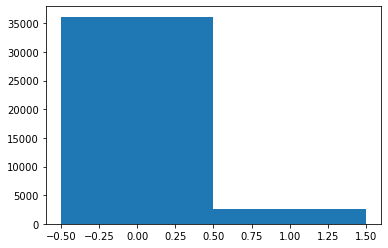

In [225]:
h = plt.hist( batched_g.edata['on_path'].data.numpy() ,bins=[-0.5,0.5,1.5])
print(h[0])
print(h[0][0]/h[0][1])
plt.show()

In [227]:
import torch.nn as nn
import torch.optim as optim


loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.0))
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [228]:
def compute_f1_and_loss(dataloader,net):
    
    edge_true_pos = 0
    edge_false_pos = 0
    edge_false_neg = 0
    
    node_true_pos = 0
    node_false_pos = 0
    node_false_neg = 0

    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for batched_g in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                batched_g = batched_g.to(torch.device('cuda'))
                
            net(batched_g)
            
            edge_target = batched_g.edata['on_path']
            edge_pred = batched_g.edata['prediction']
            
            node_target = batched_g.ndata['on_path']
            node_pred = batched_g.ndata['prediction']
            
            loss+= loss_func(edge_pred,edge_target).item()+loss_func(node_pred,node_target).item()
            
            edge_true_pos+=len(torch.where( (edge_pred>0) & (edge_target==1) )[0])
            edge_false_pos+=len(torch.where( (edge_pred>0) & (edge_target==0) )[0])
            edge_false_neg+=len(torch.where( (edge_pred<0) & (edge_target==1) )[0])
            
            node_true_pos+=len(torch.where( (node_pred>0) & (node_target==1) )[0])
            node_false_pos+=len(torch.where( (node_pred>0) & (node_target==0) )[0])
            node_false_neg+=len(torch.where( (node_pred<0) & (node_target==1) )[0])
            
    f1_edge = edge_true_pos/(edge_true_pos+0.5*(edge_false_pos+edge_false_neg))
    f1_node = node_true_pos/(node_true_pos+0.5*(node_false_pos+node_false_neg))
    loss = loss/n_batches      
    return f1_edge, f1_node, loss

In [229]:
if torch.cuda.is_available():
    net.cuda()

In [230]:
compute_f1_and_loss(validation_data_loader,net)

(0.0, 0.0, 3.212619287627084)

In [238]:
from tqdm import tqdm

n_epochs = 100


training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_f1_edge_vs_epoch = []
training_f1_node_vs_epoch = []
validation_f1_edge_vs_epoch = []
validation_f1_node_vs_epoch = []


pbar = tqdm( range(n_epochs) )

for epoch in pbar: 
    
    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description(
              ' val f1 node:'+'{0:.5f}'.format(validation_f1_node_vs_epoch[-1])+
               ' val f1 edge:'+'{0:.5f}'.format(validation_f1_edge_vs_epoch[-1]) )
        
    net.train() # put the net into "training mode"
    for batched_g in tqdm(data_loader):
        if torch.cuda.is_available():
            batched_g = batched_g.to(torch.device('cuda'))
            
            
        optimizer.zero_grad()
        net(batched_g)
        edge_target = batched_g.edata['on_path']
        edge_pred = batched_g.edata['prediction']
            
        node_target = batched_g.ndata['on_path']
        node_pred = batched_g.ndata['prediction']
        
        loss = loss_func(edge_pred,edge_target)+loss_func(node_pred,node_target)
        loss.backward()
        optimizer.step()
    
    net.eval() #put the net into evaluation mode
    train_f1_edge, train_f1_node, train_loss = compute_f1_and_loss(data_loader,net)
    valid_f1_edge, valid_f1_node, valid_loss =  compute_f1_and_loss(validation_data_loader,net)
         
    training_loss_vs_epoch.append(train_loss)    
    training_f1_edge_vs_epoch.append( train_f1_edge )
    training_f1_node_vs_epoch.append( train_f1_node )
    
    
    validation_f1_edge_vs_epoch.append(valid_f1_edge)
    validation_f1_node_vs_epoch.append(valid_f1_node)
    validation_loss_vs_epoch.append(valid_loss)
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')

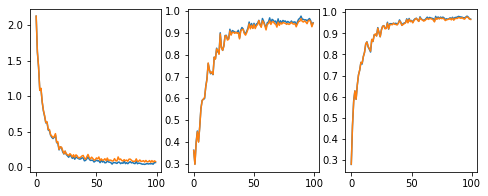

In [232]:
fig,ax = plt.subplots(1,3,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')

ax[1].plot(training_f1_edge_vs_epoch)
ax[1].plot(validation_f1_edge_vs_epoch)

ax[2].plot(training_f1_node_vs_epoch)
ax[2].plot(validation_f1_node_vs_epoch)
plt.show()

In [233]:
net.load_state_dict(torch.load('trained_model.pt'))

<All keys matched successfully>

In [234]:
for batched_g in validation_data_loader:
    break
net.eval()
net.cuda()
if torch.cuda.is_available():
    batched_g = batched_g.to(torch.device('cuda'))
net(batched_g)
predictions = batched_g.edata['prediction'].cpu().data.numpy()
sigmoid_predictions =  torch.sigmoid(batched_g.edata['prediction']).cpu().data.numpy()
targets = batched_g.edata['on_path'].cpu().data.numpy()

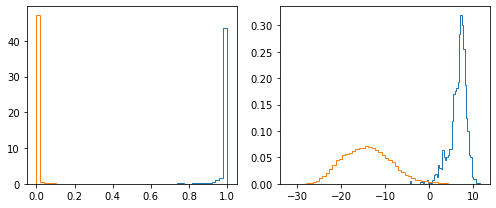

In [235]:
import numpy as np
fig,ax = plt.subplots(1,2,figsize=(7,3))

ax[0].hist(sigmoid_predictions[targets==1],histtype='step',bins=np.linspace(0,1,50),density=True)
ax[0].hist(sigmoid_predictions[targets==0],histtype='step',bins=np.linspace(0,1,50),density=True)

ax[1].hist(predictions[targets==1],histtype='step',bins=50,density=True)
ax[1].hist(predictions[targets==0],histtype='step',bins=50,density=True)

plt.tight_layout()
plt.show()

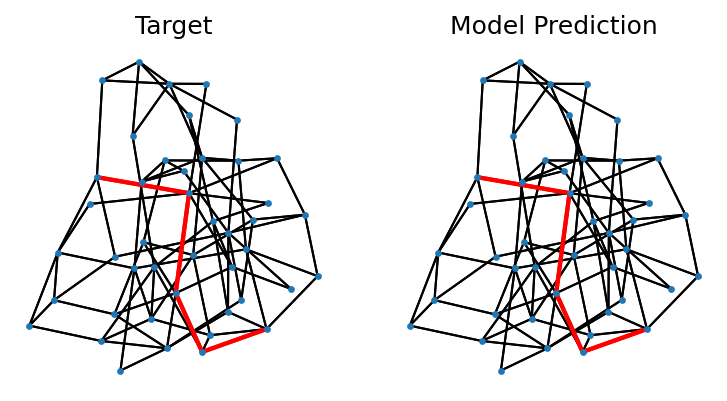

In [237]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')
net.eval()
net.cpu()

g = validation_dataset[666]
net(g)


output_pred = torch.sigmoid(g.edata['prediction']).data.numpy()

nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(g.nodes().data.numpy())
nx_graph.add_edges_from([(es.item(),ee.item()) for es,ee in zip(g.edges()[0],g.edges()[1])])

edge_dict = {(s.item(),e.item()) : on_path.item() for s,e,on_path in zip(g.edges()[0],g.edges()[1],
                                                                         g.edata['on_path'])}

edge_prediction_dict = {(s.item(),e.item()) : pred.item() for s,e,pred in zip(g.edges()[0],g.edges()[1],
                                                                         output_pred)}

edge_list = [e for i,e in enumerate(nx_graph.edges) if edge_dict[e]>0]

predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if edge_prediction_dict[e]>0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

plt.show()